# 1. Business Understanding

When it comes to blockbuster, everyone will give credit to its production team, its lead actors, its genres, and its scripts. But even though all these factors are the same, the success of a blockbuster still can’t be replicated. So, we want to know what else makes a movie blockbuster? 
For this project, our target users and stakeholders are movie production companies, film producers, and publishers who need to decide in advance when and where to issue a movie. And directors and actors who want to choose a potential blockbuster to join in. Basically everyone related to the movie hope the movie to be a success. Besides all the factors we’ve mentioned above, they hope everything else to be stimulative for a blockbuster like what time to issue a movie, what other factors should be taken into considerations.
Currently, most movie production companies and film producers focus on production team which includes directors and lead actors, and directors and actors focus on script itself. Only publishers might focus on when and where to launch a movie.
The purpose of this project is to minimize the cost of marketing and maximize the revenue of the movie. Also, we hope it can help a movie to be a success.
In this project, we analyze the relationship between different factors and blockbusters. And we use a simple model to predict what makes a movie blockbuster.

In [1]:
import urllib.request
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.decomposition import PCA



#from model import run_model

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format

# 2.Data Understanding

What are the potential external factors that could affect a movie's success?
Launch time
Economic factors: GDP, CPI, unemployment rate.
Political factors: President of the country.
Social factors: Alchol consumptions

# Importing all the datas into their respective DF

In [2]:
IMDBmovies = pd.read_csv('IMDb movies.csv')
IMDBmovies = IMDBmovies.rename({'title': 'IMDB_Title'}, axis='columns')
        
Presidents_df = pd.read_csv('presidents.csv',encoding= 'unicode_escape')

GDP_df = pd.read_csv('GDP.csv',delimiter='\t')
CPI_df = pd.read_csv('CPI.csv')
Unemployment_df = pd.read_csv('Unemployment.csv')

beer_data = pd.read_csv('beer-consumption-per-person.csv')
beer_data = beer_data.rename({'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Beer': 'Beer','Entity':'Country'}, axis='columns')


spirits_data = pd.read_csv('spirits-consumption-per-person.csv')
spirits_data = spirits_data.rename({'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Spirits': 'Spirits','Entity':'Country'}, axis='columns')

wine_data = pd.read_csv('wine-consumption-per-person.csv')
wine_data = wine_data.rename({'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Wine': 'Wine','Entity':'Country'}, axis='columns')

wine_data.shape

(8953, 4)

# Cleaning up the IMDB dataset 

In [3]:
# Cleaning up IMDB and settting the column types
def clean_df(df):
    cleanimdb_df = df
    cleanimdb_df = cleanimdb_df.drop(columns=['year','language','imdb_title_id','actors', 'description','votes','metascore','reviews_from_users','reviews_from_critics'])#drops the four extra columns since 
    cleanimdb_df = cleanimdb_df.dropna() # Dropping any rows with null value
    cleanimdb_df['IMDB_Title'] = cleanimdb_df['IMDB_Title'].astype('string')
    cleanimdb_df['original_title'] = cleanimdb_df['original_title'].astype('string')
    cleanimdb_df.reset_index(inplace=True)
    cleanimdb_df = cleanimdb_df.drop(columns = 'index')
    cleanimdb_df[["date_published"]] = pd.to_datetime(cleanimdb_df["date_published"])
    
    
    cleanimdb_df['genre'] = cleanimdb_df['genre'].str.split(",").apply(lambda x: x[0]).str.replace(' ', '').astype('string')
    
    cleanimdb_df['duration'] = cleanimdb_df['duration'].astype('float')
    cleanimdb_df['country'] = cleanimdb_df['country'].astype('string')
    
    cleanimdb_df = cleanimdb_df.loc[cleanimdb_df['country'] == 'USA'] # Looking at only US based movies
    cleanimdb_df['production_company'] = cleanimdb_df['production_company'].astype('string')
    cleanimdb_df['avg_vote'] = cleanimdb_df['avg_vote'].astype('float')
    cleanimdb_df['budget'] = cleanimdb_df['budget'].str.split().apply(lambda x: x[1]).str.replace('$', ' ').astype(float) #replace all commas and converts the column to int
    cleanimdb_df['usa_gross_income'] = cleanimdb_df['usa_gross_income'].str.split().apply(lambda x: x[1]).str.replace('$', ' ').astype(float) #replace all commas and converts the column to int
    cleanimdb_df['worlwide_gross_income'] = cleanimdb_df['worlwide_gross_income'].str.split().apply(lambda x: x[1]).str.replace('$', ' ').astype(float) #replace all commas and converts the column to int
    return cleanimdb_df
   

IMDBmovies_cleaned = clean_df(IMDBmovies)

#IMDBmovies.shape
#IMDBmovies_cleaned.isna().sum()
#IMDBmovies_cleaned.year.unique()
IMDBmovies_cleaned.budget.unique()
IMDBmovies_cleaned.head().T

,1,3,4,6,7
IMDB_Title,I quattro cavalieri dell'Apocalisse,Luci della città,Tempi moderni,Biancaneve e i sette nani,Via col vento
original_title,The Four Horsemen of the Apocalypse,City Lights,Modern Times,Snow White and the Seven Dwarfs,Gone with the Wind
date_published,1923-04-16 00:00:00,1931-04-02 00:00:00,1937-03-12 00:00:00,1938-11-30 00:00:00,1949-03-12 00:00:00
genre,Drama,Comedy,Comedy,Animation,Drama
duration,150.00,87.00,87.00,83.00,238.00
country,USA,USA,USA,USA,USA
director,Rex Ingram,Charles Chaplin,Charles Chaplin,"William Cottrell, David Hand","Victor Fleming, George Cukor"
writer,"Vicente Blasco Ibáñez, June Mathis",Charles Chaplin,Charles Chaplin,"Jacob Grimm, Wilhelm Grimm","Margaret Mitchell, Sidney Howard"
production_company,Metro Pictures Corporation,Charles Chaplin Productions,Charles Chaplin Productions,Walt Disney Productions,Selznick International Pictures
avg_vote,7.20,8.50,8.50,7.60,8.10


# Feature creation from IMDB

In [4]:
# using IMDB data to create features
IMDBmovies_blockbusters = IMDBmovies_cleaned #copying IMDBmvoies to another df for feature creation
IMDBmovies_blockbusters['profit'] = (IMDBmovies_blockbusters['worlwide_gross_income']+ IMDBmovies_blockbusters['usa_gross_income'])-IMDBmovies_blockbusters['budget']
IMDBmovies_blockbusters['Blockbuster'] = 0
IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters['profit']>10*IMDBmovies_blockbusters['budget'],'Blockbuster']=1


IMDBmovies_blockbusters["year"] = IMDBmovies_blockbusters["date_published"].dt.year
IMDBmovies_blockbusters["month"] = IMDBmovies_blockbusters["date_published"].dt.month
IMDBmovies_blockbusters['holiday'] = 0 # the default shall be a zero which means it is not a holiday

minyear = IMDBmovies_blockbusters["date_published"].dt.year.min()
maxyear = IMDBmovies_blockbusters["date_published"].dt.year.max()
cal = calendar()
holidays = cal.holidays(start= str(minyear)+'-01-01', end = str(maxyear)+'-12-31') #gets the holidays from the min year to the max year in the data
IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters[IMDBmovies_blockbusters['date_published'].isin(holidays)].index, 'holiday'] = 1 #adds a 1 to the holiday coulmn where the condition matches.

IMDBmovies_blockbusters['workingday'] = 1 # the default shall be a one which means it is a working day
IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters[IMDBmovies_blockbusters['date_published'].isin(holidays)].index, 'workingday'] = 0  #adds a 0 to the workingday column to indicate that it is not a working day
IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters[IMDBmovies_blockbusters['date_published'].dt.weekday == 5].index, 'workingday'] = 0 #adds a 0 to the workingday column to indicate that it is a saturday
IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters[IMDBmovies_blockbusters['date_published'].dt.weekday == 6].index, 'workingday'] = 0 #adds a 0 to the workingday column to indicate that it is a sunday
#5 and 6 are Saturdays and Sundays
IMDBmovies_blockbusters['dayofweek'] = IMDBmovies_blockbusters['date_published'].dt.weekday



#print(data[data['dteday'].dt.weekday == 0]) 

IMDBmovies_blockbusters['date_published'] = IMDBmovies_blockbusters['date_published'].dt.dayofyear # converting it back to numerical
IMDBmovies_blockbusters = IMDBmovies_blockbusters.rename({'date_published': 'day_of_year'}, axis='columns')

IMDB_Moviecount_df = IMDBmovies_blockbusters.groupby(['year']).count()
IMDB_Moviecount_df = IMDB_Moviecount_df['IMDB_Title']
IMDBmovies_blockbusters = pd.merge(IMDB_Moviecount_df,IMDBmovies_blockbusters,how='right', left_on=['year'], right_on=['year'])
IMDBmovies_blockbusters = IMDBmovies_blockbusters.rename({'IMDB_Title_x': 'Total_Movie_count', 'IMDB_Title_y':'IMDB_Title'}, axis='columns')


In [5]:
IMDBmovies_blockbusters_encoded = IMDBmovies_blockbusters.copy()

In [6]:

for col in ['IMDB_Title','original_title','production_company','genre','country']:
    IMDBmovies_blockbusters_encoded[col] = IMDBmovies_blockbusters_encoded[col].astype('category') # Convert to category type
    IMDBmovies_blockbusters_encoded[col] = IMDBmovies_blockbusters_encoded[col].cat.codes # Convert to numerical code
    
    
categories=IMDBmovies_blockbusters.director.unique()

IMDBmovies_blockbusters_encoded['director'] = IMDBmovies_blockbusters_encoded['director'].astype('category') # Convert type to category
IMDBmovies_blockbusters_encoded['director'].cat.set_categories(categories, ordered=True, inplace=True) # Set ordered categories
IMDBmovies_blockbusters_encoded['director'] = IMDBmovies_blockbusters_encoded['director'].cat.codes # Convert to numerical codes
IMDBmovies_blockbusters_encoded.head()

categories=IMDBmovies_blockbusters.writer.unique()

IMDBmovies_blockbusters_encoded['writer'] = IMDBmovies_blockbusters_encoded['writer'].astype('category') # Convert type to category
IMDBmovies_blockbusters_encoded['writer'].cat.set_categories(categories, ordered=True, inplace=True) # Set ordered categories
IMDBmovies_blockbusters_encoded['writer'] = IMDBmovies_blockbusters_encoded['writer'].cat.codes # Convert to numerical codes

#IMDBmovies_blockbusters_encoded['country'] = IMDBmovies_blockbusters_encoded['region'].astype('category') # Convert type to category
#IMDBmovies_blockbusters_encoded = pd.get_dummies(data=IMDBmovies_blockbusters_encoded, columns=['region']) # One-hot encode
IMDBmovies_blockbusters_encoded = IMDBmovies_blockbusters_encoded.drop(columns=['country'])  
    
IMDBmovies_blockbusters_encoded.head().T

,0,1,2,3,4
year,"1,923.00","1,931.00","1,937.00","1,938.00","1,949.00"
Total_Movie_count,1.00,1.00,1.00,1.00,2.00
IMDB_Title,"1,548.00","2,433.00","3,604.00",441.00,"4,198.00"
original_title,"3,396.00",680.00,"2,110.00","2,904.00","1,322.00"
day_of_year,106.00,92.00,71.00,334.00,71.00
genre,7.00,4.00,4.00,2.00,7.00
duration,150.00,87.00,87.00,83.00,238.00
director,0.00,1.00,1.00,2.00,3.00
writer,0.00,1.00,1.00,2.00,3.00
production_company,"1,081.00",390.00,390.00,"1,557.00","1,363.00"


# Visualizing the IMDB dataset with all the features

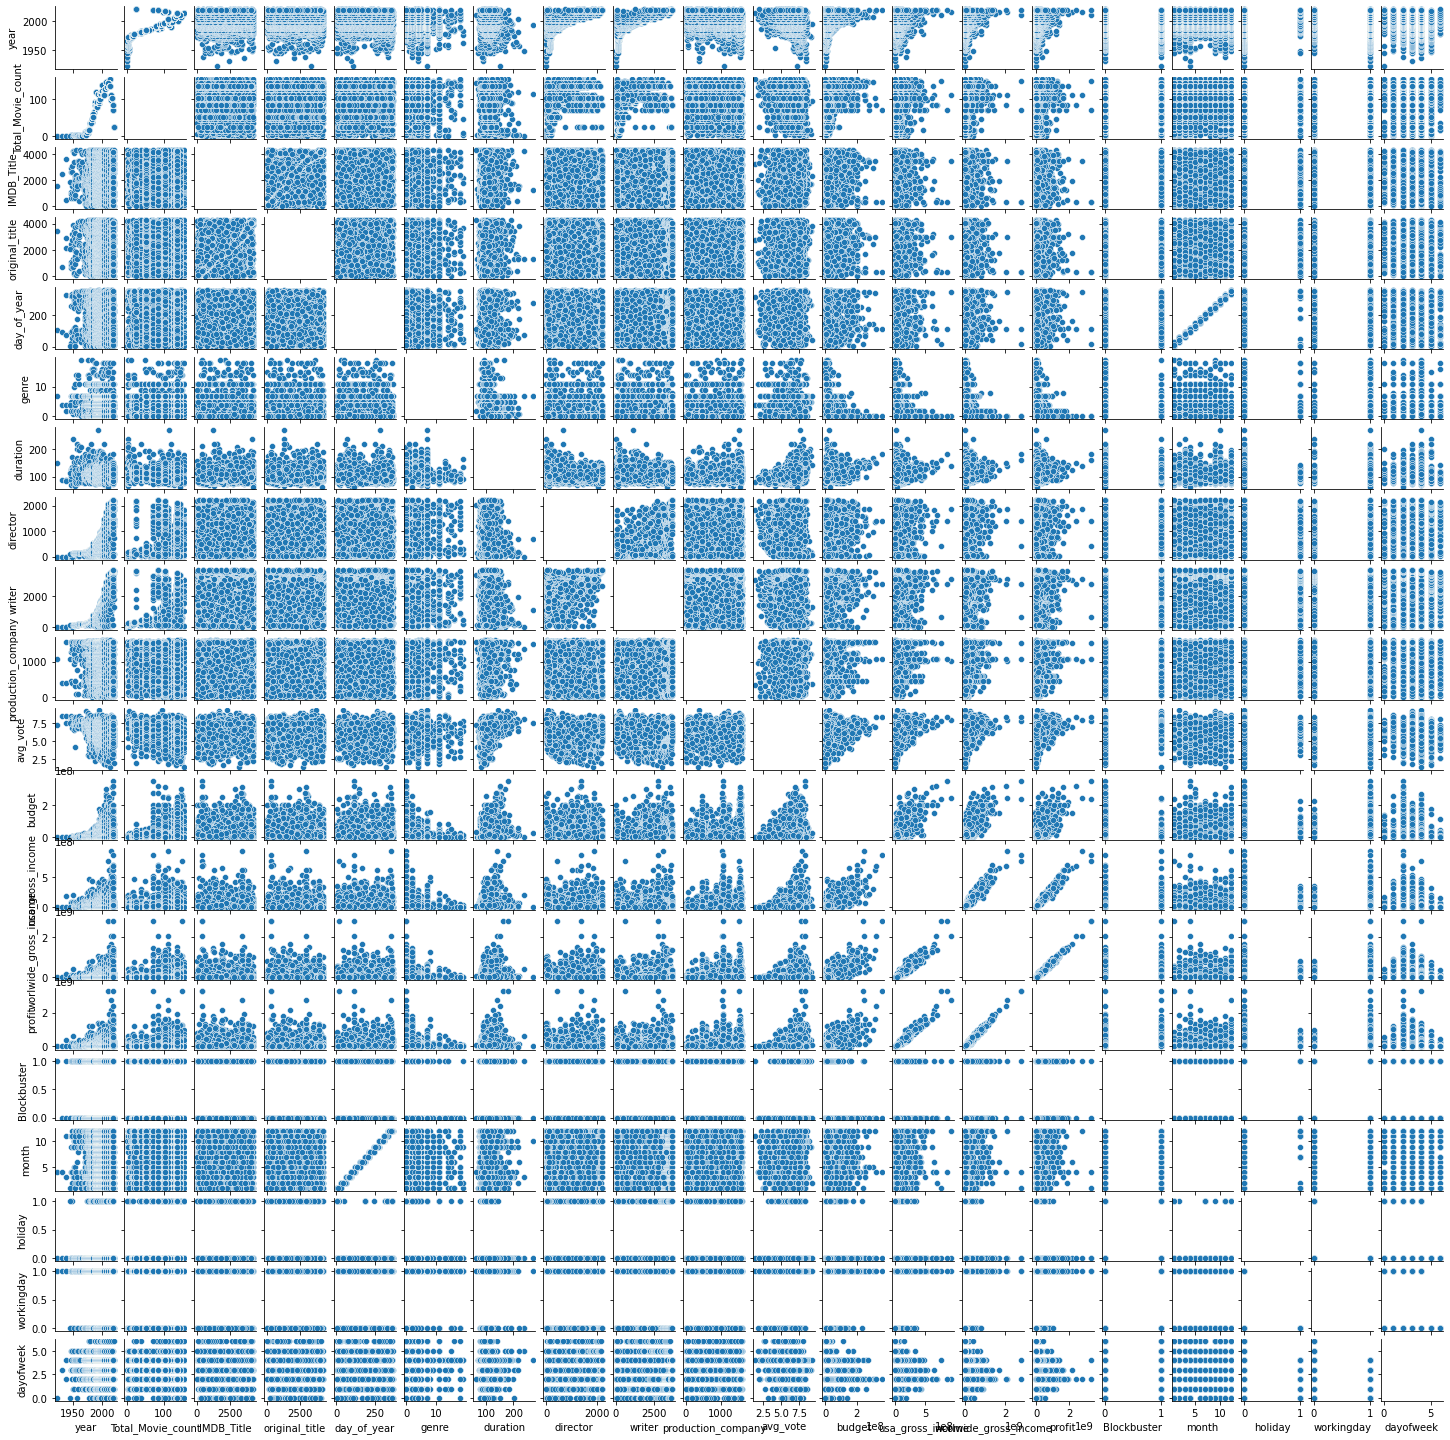

In [7]:
g = sns.pairplot(data=IMDBmovies_blockbusters_encoded,diag_kind='reg')
g.fig.set_size_inches(20,20)

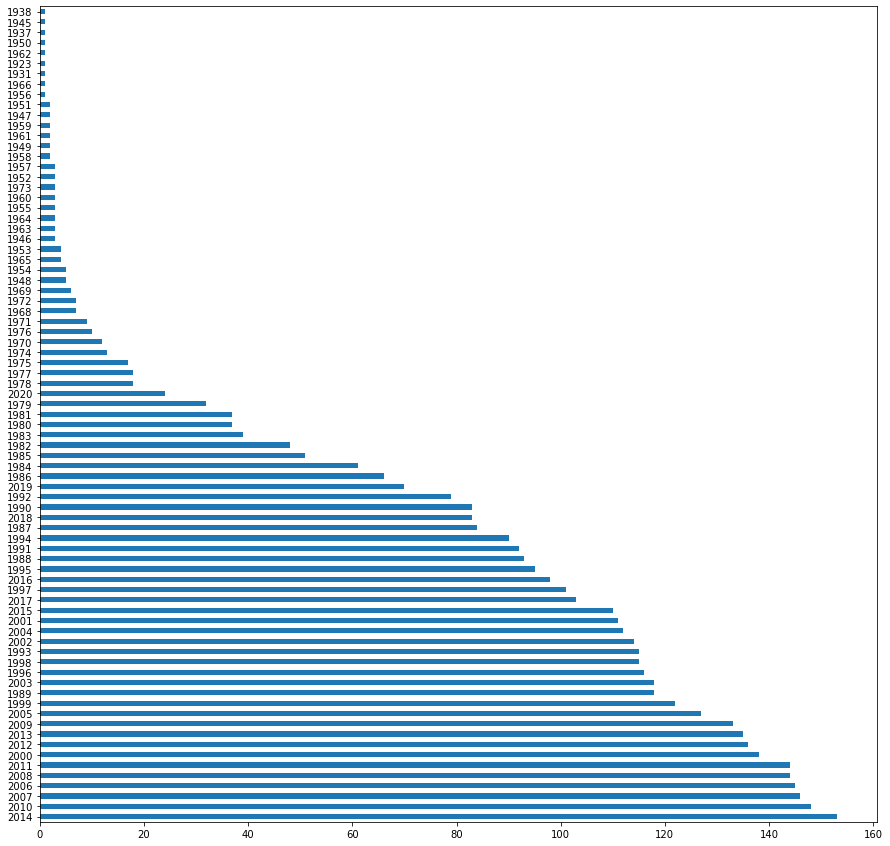

In [8]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
IMDBmovies_blockbusters['year'].value_counts().plot(kind='barh',ax=ax)

In [9]:
IMDBmovies_blockbusters_encoded.production_company.unique()

array([1081,  390, 1557, ...,  820,  684, 1528], dtype=int16)

Text(0, 0.5, 'budget')

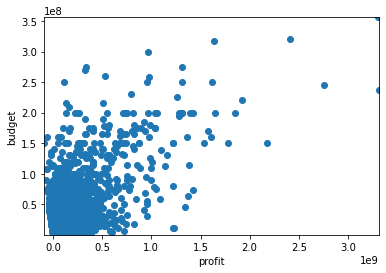

In [10]:
x=IMDBmovies_blockbusters_encoded['profit']
y=IMDBmovies_blockbusters_encoded['budget']

plt.scatter(x,y)
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.xlabel('profit')
plt.ylabel('budget')
#IMDBmovies_blockbusters.genre.unique()

#IMDBmovies_blockbusters.loc[IMDBmovies_blockbusters['country'] == 'USA']

Text(0, 0.5, 'Profit')

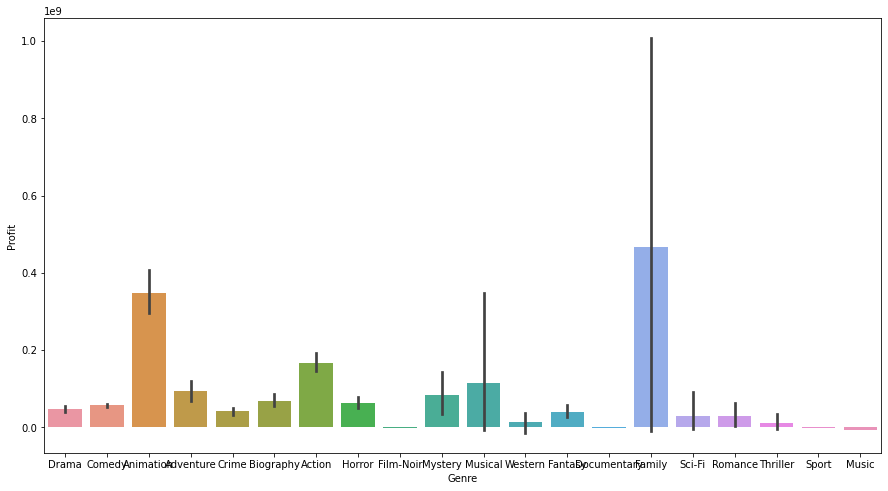

In [11]:
#f, ax = plt.subplots(figsize=(18,5))
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=IMDBmovies_blockbusters['genre'], y=IMDBmovies_blockbusters['profit'],ax=ax)
plt.xlabel('Genre')
plt.ylabel('Profit')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
 <a list of 79 Text major ticklabel objects>)

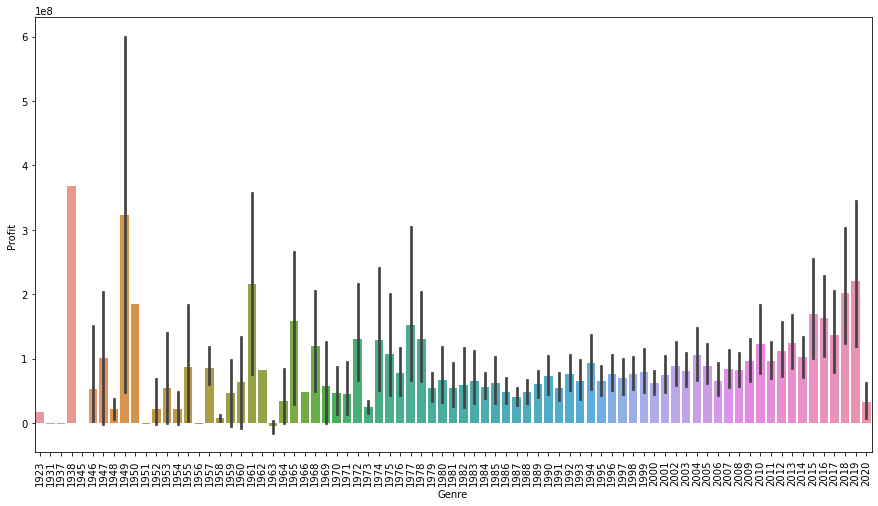

In [12]:
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=IMDBmovies_blockbusters_encoded['year'], y=IMDBmovies_blockbusters_encoded['profit'],ax=ax)
plt.xlabel('Genre')
plt.ylabel('Profit')
plt.xticks(rotation=90)

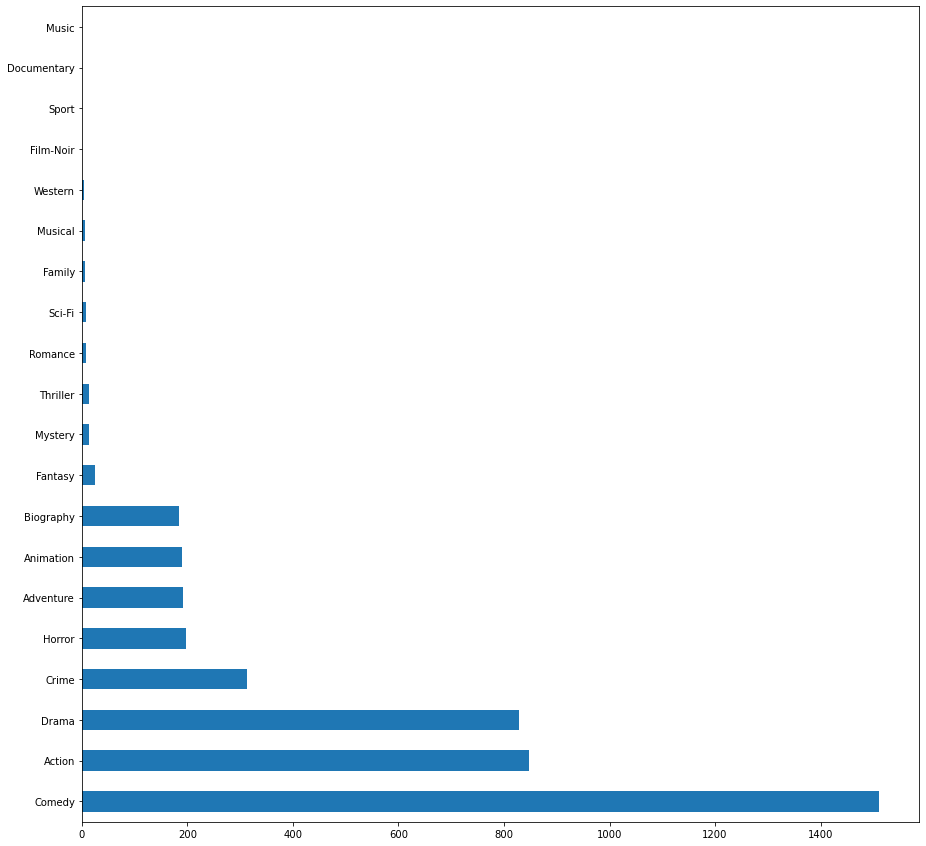

In [13]:
fig_dims = (15, 15)
fig, ax = plt.subplots(figsize=fig_dims)
IMDBmovies_blockbusters['genre'].value_counts().plot(kind='barh',ax=ax)

# Creating a default model for IMDB to compare

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

X = IMDBmovies_blockbusters_encoded['Blockbuster']
X=X.values.reshape(-1,1)
Y = IMDBmovies_blockbusters_encoded[IMDBmovies_blockbusters_encoded.drop(columns = ['Blockbuster']).columns]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2) # giving a 80 - 20 test, train split
model = LinearRegression().fit(x_train, y_train)
predictions = model.predict(x_test)
R_squared = r2_score(y_test, predictions)
MSE = metrics.mean_absolute_error(y_test, predictions)
RMSE = np.sqrt(MSE)
print(R_squared)
print(MSE)
print(RMSE)
print(model.score(x_train, y_train))


0.011185195105034637
13133679.56752883
3624.041882695181
0.018565047995384814


# Feature Selection

In [16]:
cont_vars = ['budget','usa_gross_income','worlwide_gross_income','Total_Movie_count','duration'] # Continuous variables
cat_vars = ['Blockbuster','year','director','writer','IMDB_Title','original_title','genre',
            'production_company','avg_vote','day_of_year','month','holiday','workingday','dayofweek'] # Catogrorical Variables

subsample = IMDBmovies_blockbusters_encoded.sample(n=100)
X = subsample.drop(labels=['profit'],axis=1)
y = subsample['profit']

cont_data = X[cont_vars]

ftest = SelectKBest(score_func=f_regression, k='all')
fit_ftest = ftest.fit(cont_data,y)
f_scores = pd.DataFrame(fit_ftest.scores_)
dfcolumns = pd.DataFrame(cont_data.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores

#data_feat_sel.head()
#print(data)

,Feature,F-Score
0,budget,8.33
1,usa_gross_income,"1,278.58"
2,worlwide_gross_income,937.48
3,Total_Movie_count,2.92
4,duration,2.37


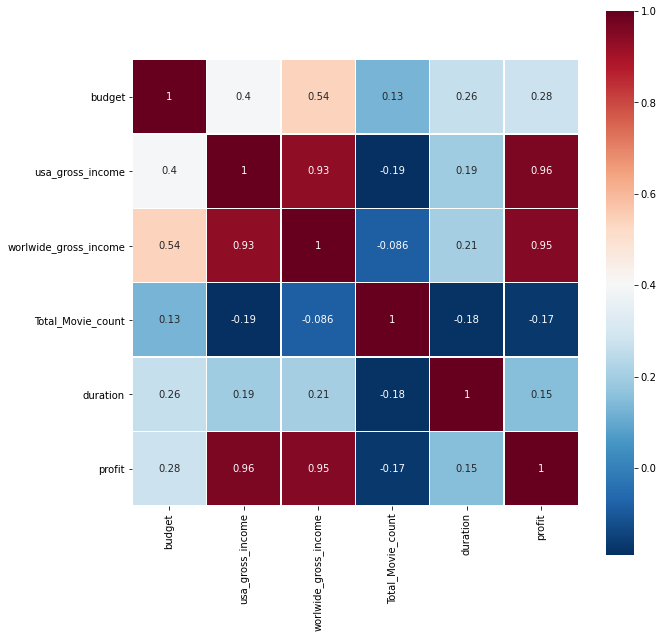

In [17]:
fig, ax = plt.subplots(figsize=(10,10)) 
feats = subsample[cont_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

In [18]:
# Categorical features - need to convert to numerical codes
cat_data = X.drop(labels=cont_vars,axis=1)
#cat_data = cat_data.astype('category')
#cat_data = cat_data.apply(lambda x: x.cat.codes,axis=0)

# Run mutual info test
mutual_info_test = SelectKBest(score_func=mutual_info_regression, k='all')
mutual_info_fit = mutual_info_test.fit(cat_data,y)

# Put scores and features names in a dataframe
mi_scores = pd.DataFrame(mutual_info_fit.scores_)
dfcolumns = pd.DataFrame(cat_data.columns)
mi_scores = pd.concat([dfcolumns,mi_scores],axis=1)
mi_scores.columns = ['Feature','Score']  

mi_scores

,Feature,Score
0,year,0.14
1,IMDB_Title,0.00
2,original_title,0.00
3,day_of_year,0.02
4,genre,0.01
5,director,0.01
6,writer,0.08
7,production_company,0.00
8,avg_vote,0.06
9,Blockbuster,0.04


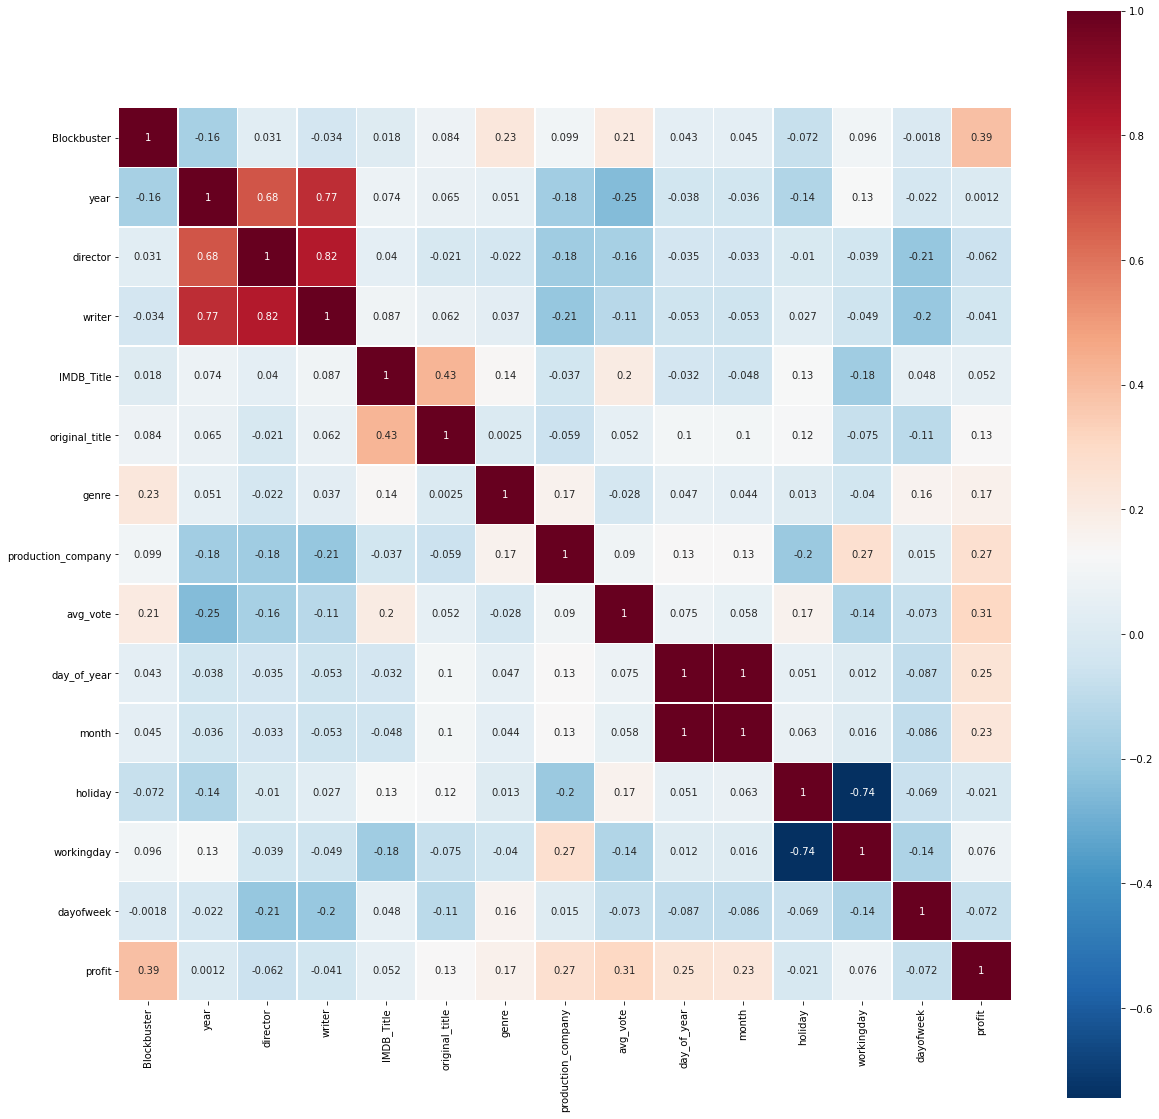

In [19]:
fig, ax = plt.subplots(figsize=(20,20)) 

feats = subsample[cat_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

# Finding Correlation with GDP,CPI,Unemployment data with IMDB

In [20]:
Unemployment_df.head()
#Unemployment_df = pd.read_csv('Unemployment.csv',delimiter='\t')

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United States,USA,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,5.50,6.70,5.50,5.70,5.20,4.50,...,8.95,8.07,7.37,6.17,5.28,4.87,4.36,3.90,3.67,nan


In [22]:
def GDP_clean_df(df):
    gdp = df
    gdp = gdp.drop(columns=['Country Name', 'Country Code','Indicator Name', 'Indicator Code'])#drops the four extra columns since 
    gdp.index = range(len(gdp))
    gdp = gdp.T
    gdp.reset_index(inplace=True)
    gdp.columns = ['year','GDP']
    gdp['year'] = gdp['year'].astype(int)
    #gdp[["year"]] = gdp[["year"]].apply(pd.to_datetime)
    #gdp['GDP'] = gdp['GDP'].astype('float')
    return gdp

GDP_df_cleaned = GDP_clean_df(GDP_df)
# since the CPI and Enplyment data are the same strucute I am using the same fundtion to clean them 
CPI_df_cleaned = GDP_clean_df(CPI_df)
CPI_df_cleaned = CPI_df_cleaned.rename({'GDP': 'CPI'}, axis='columns')
Unemployment_df_cleaned = GDP_clean_df(Unemployment_df)
Unemployment_df_cleaned = Unemployment_df_cleaned.rename({'GDP': 'Unemployment'}, axis='columns')

Unemployment_df_cleaned.head()
#GDP_df_cleaned.dtypes

,year,Unemployment
0,1960,5.50
1,1961,6.70
2,1962,5.50
3,1963,5.70
4,1964,5.20


# Merging CDP,CPI and Unemployment

In [23]:
Stats_MERGE = pd.merge(GDP_df_cleaned,CPI_df_cleaned,how='right', left_on=['year'], right_on=['year'])
Stats_MERGE = pd.merge(Unemployment_df_cleaned,Stats_MERGE,how='right', left_on=['year'], right_on=['year'])
Stats_MERGE.head().T

,0,1,2,3,4
year,"1,960.00","1,961.00","1,962.00","1,963.00","1,964.00"
Unemployment,5.50,6.70,5.50,5.70,5.20
GDP,"543,300,000,000.00","563,300,000,000.00","605,100,000,000.00","638,600,000,000.00","685,800,000,000.00"
CPI,13.56,13.71,13.87,14.04,14.22


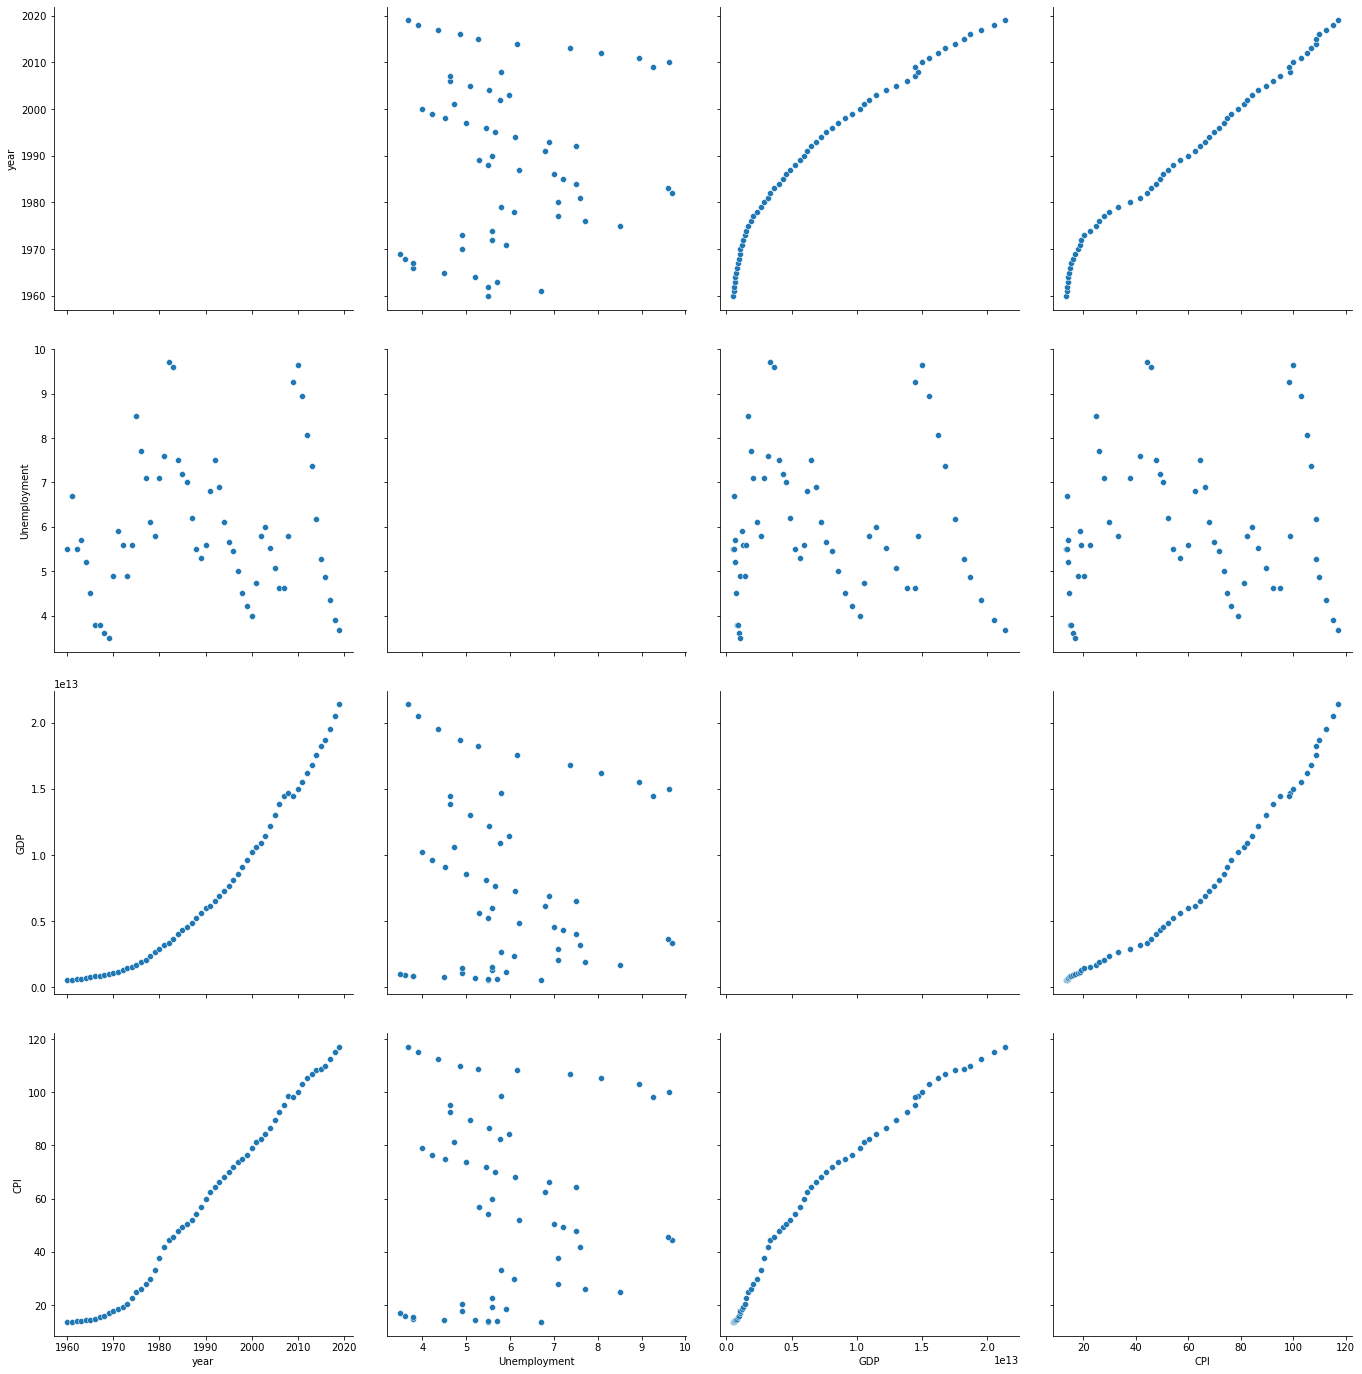

In [24]:
g = sns.pairplot(data=Stats_MERGE,diag_kind='reg')
g.fig.set_size_inches(20,20)

In [25]:
IMDB_MERGE = pd.merge(Stats_MERGE,IMDBmovies_blockbusters_encoded,how='right', left_on=['year'], right_on=['year'])
IMDB_MERGE = IMDB_MERGE.dropna() # Dropping any rows with null value
#print(IMDB_MERGE.isna().sum(),IMDB_MERGE.shape)
IMDB_MERGE.head().T

,16,17,18,19,20
year,"2,002.00","2,002.00","2,002.00","2,002.00","2,002.00"
Unemployment,5.78,5.78,5.78,5.78,5.78
GDP,"10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00"
CPI,82.49,82.49,82.49,82.49,82.49
Total_Movie_count,114.00,114.00,114.00,114.00,114.00
IMDB_Title,"1,944.00","2,521.00","3,482.00","1,715.00","3,444.00"
original_title,"1,746.00","2,056.00","2,990.00","4,005.00","2,950.00"
day_of_year,60.00,256.00,136.00,354.00,158.00
genre,4.00,0.00,0.00,2.00,0.00
duration,118.00,88.00,142.00,95.00,121.00


In [26]:
cont_vars = ['Unemployment','CPI','GDP','budget','usa_gross_income','worlwide_gross_income','Total_Movie_count','duration'] # Continuous variables
cat_vars = ['Blockbuster','year','director','writer','IMDB_Title','original_title','genre',
            'production_company','avg_vote','day_of_year','month','holiday','workingday','dayofweek'] # Catogrorical Variables

subsample = IMDB_MERGE.sample(n=100)
X = subsample.drop(labels=['profit'],axis=1)
y = subsample['profit']

cont_data = X[cont_vars]

ftest = SelectKBest(score_func=f_regression, k='all')
fit_ftest = ftest.fit(cont_data,y)
f_scores = pd.DataFrame(fit_ftest.scores_)
dfcolumns = pd.DataFrame(cont_data.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores

#data_feat_sel.head()
#print(data)

,Feature,F-Score
0,Unemployment,0.16
1,CPI,0.39
2,GDP,0.27
3,budget,62.32
4,usa_gross_income,"1,290.11"
5,worlwide_gross_income,"1,578.77"
6,Total_Movie_count,0.18
7,duration,0.18


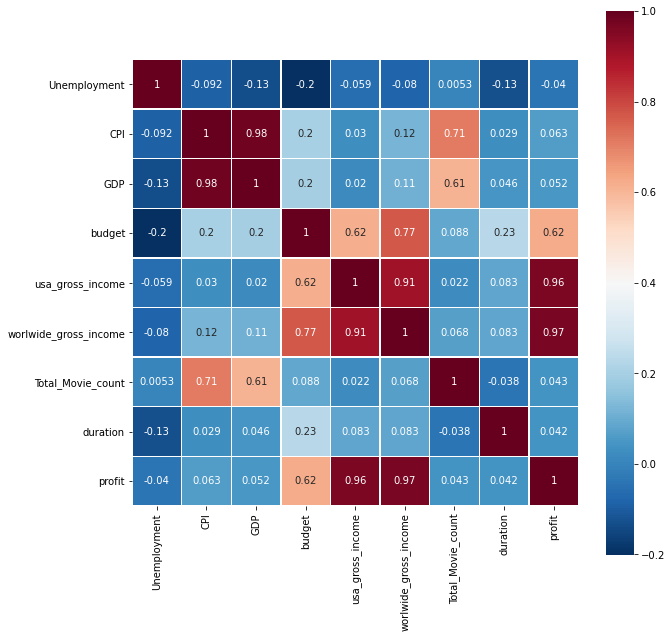

In [27]:
fig, ax = plt.subplots(figsize=(10,10)) 
feats = subsample[cont_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

In [28]:
# Categorical features - need to convert to numerical codes
cat_data = X.drop(labels=cont_vars,axis=1)
#cat_data = cat_data.astype('category')
#cat_data = cat_data.apply(lambda x: x.cat.codes,axis=0)

# Run mutual info test
mutual_info_test = SelectKBest(score_func=mutual_info_regression, k='all')
mutual_info_fit = mutual_info_test.fit(cat_data,y)

# Put scores and features names in a dataframe
mi_scores = pd.DataFrame(mutual_info_fit.scores_)
dfcolumns = pd.DataFrame(cat_data.columns)
mi_scores = pd.concat([dfcolumns,mi_scores],axis=1)
mi_scores.columns = ['Feature','Score']  

mi_scores

,Feature,Score
0,year,0.11
1,IMDB_Title,0.00
2,original_title,0.00
3,day_of_year,0.00
4,genre,0.12
5,director,0.00
6,writer,0.08
7,production_company,0.00
8,avg_vote,0.00
9,Blockbuster,0.03


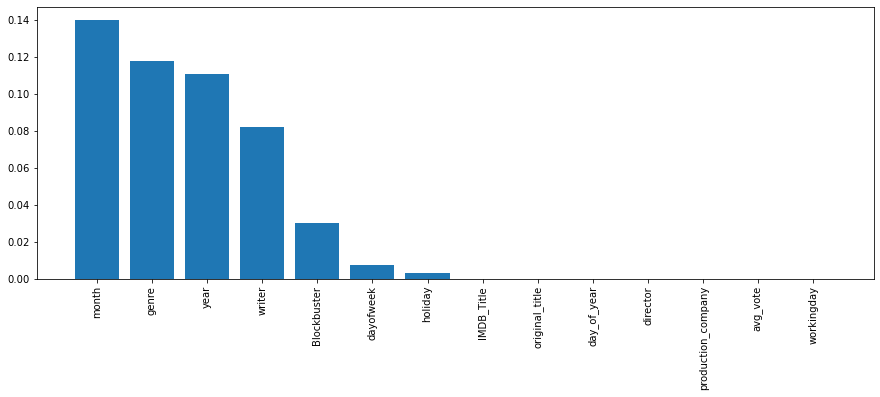

In [29]:
# Sort them by value
mi_scores = mi_scores.sort_values(by='Score',ascending=False)

# Plot scores
plt.figure(figsize=(15,5))
plt.bar(x=mi_scores['Feature'],height=mi_scores['Score'])
plt.xticks(rotation=90)
plt.show()

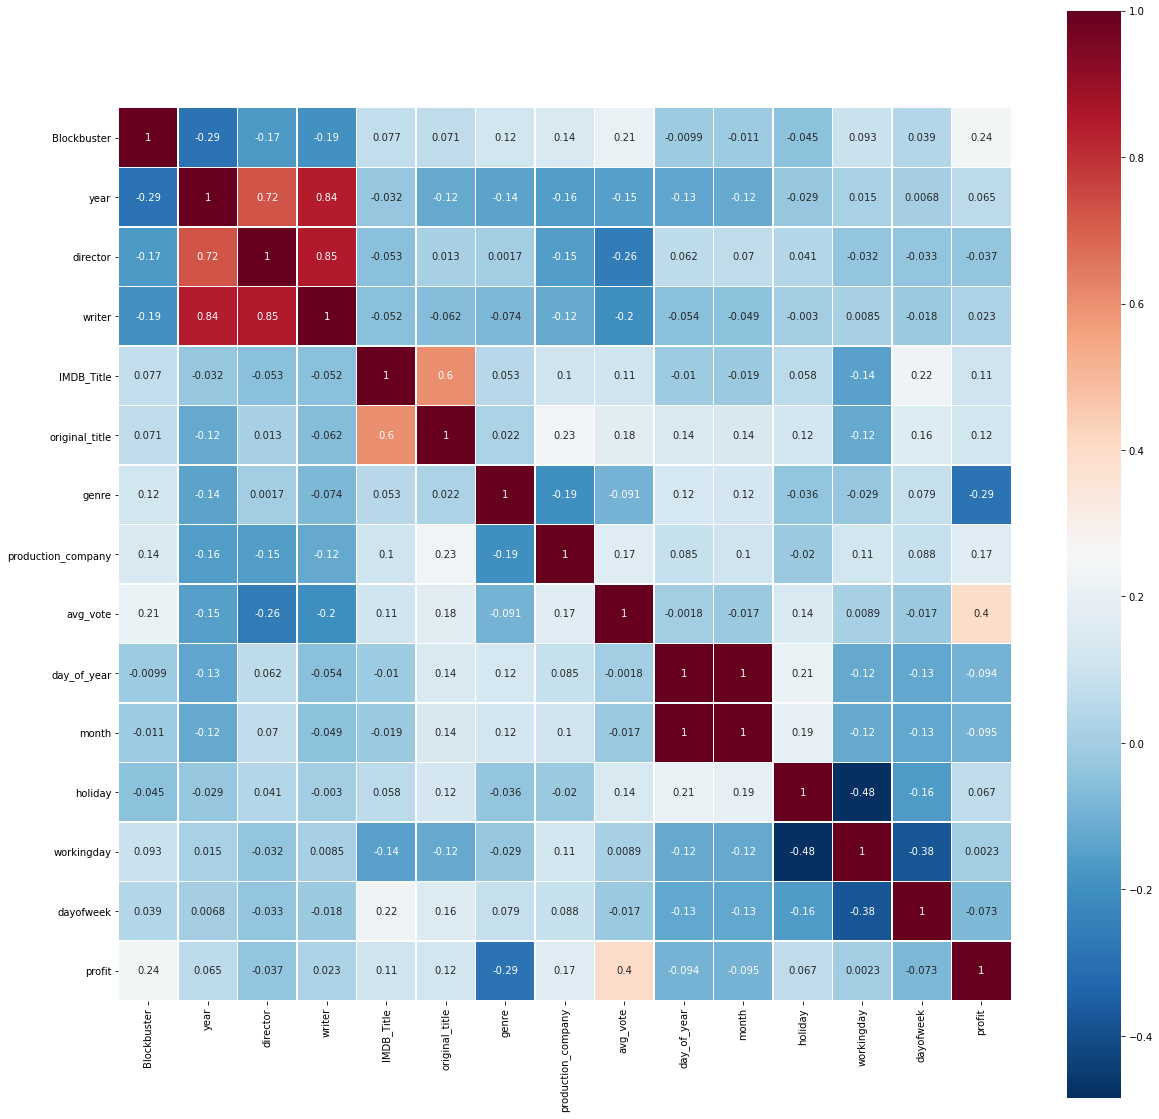

In [30]:
fig, ax = plt.subplots(figsize=(20,20)) 

feats = subsample[cat_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

# Correlation between Presidents of US and Boxoffice

In [32]:
import math
def President_clean_df(df):
    President = df
    President = President[['president','start','end']]
    President['end'] = President['end'].str.replace('--', '').apply(pd.to_datetime)
    President.end.loc[President.end.isna()] = 0
    
    President[["start"]] = President[["start"]].apply(pd.to_datetime)
    President['year'] = pd.DatetimeIndex(President['start']).year 
    for index, row in President.iterrows(): # itterrate through the rows to find the total term for each row and append those years as a running number with the president name
        if(row['end'] != 0):
            term = (row['end']-row['start'])
            years = (int)(math.ceil(term.days/365))
            #print(years)
            for x in range(years):
                President = President.append({'president': row['president'],'year': row['year']+x}, ignore_index=True)
                                                 
    President = President.drop(columns=['start','end'])
    return President

Presidents_df_cleaned = President_clean_df(Presidents_df)
Presidents_df_cleaned.tail(10).T
#GDP_df_cleaned.dtypes

,282,283,284,285,286,287,288,289,290,291
president,Bill Clinton,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush
year,2001,2001,2002,2003,2004,2005,2006,2007,2008,2009


In [33]:
Presidents_df_cleaned

,president,year
0,George Washington,1789
1,John Adams,1797
2,Thomas Jefferson,1801
3,James Madison,1809
4,James Monroe,1817
...,...,...
287,George W. Bush,2005
288,George W. Bush,2006
289,George W. Bush,2007
290,George W. Bush,2008


In [34]:
Presidents_df_cleaned.loc[Presidents_df_cleaned['year']==1968]

,president,year
245,Lyndon B. Johnson,1968


In [35]:
Presidents_df

,seat_no,president,birth_date,birth_place,death_date,death_loc,start,end,prior,party,vice
0,1,George Washington,"Feb 22, 1732","Westmoreland Co., Va.","Dec 14, 1799","Mount Vernon, Va.","April 30, 1789","March 4, 1797",Commander-in-Chief of the Continental Army ...,Nonpartisan [13],John Adams
1,2,John Adams,"Oct 30, 1735","Quincy, Mass.","July 4, 1826","Quincy, Mass.","March 4, 1797","March 4, 1801",1st Vice President of the United States,Federalist,Thomas Jefferson
2,3,Thomas Jefferson,"Apr 13, 1743","Albemarle Co., Va.","July 4, 1826","Albemarle Co., Va.","March 4, 1801","March 4, 1809",2nd Vice President of the United States,Democratic- Republican,Aaron Burr
3,4,James Madison,"Mar 16, 1751","Port Conway, Va.","June 28, 1836","Orange Co., Va.","March 4, 1809","March 4, 1817",5th United States Secretary of State (1801â...,Democratic- Republican,George Clinton
4,5,James Monroe,"Apr 28, 1758","Westmoreland Co., Va.","July 4, 1831","New York, New York","March 4, 1817","March 4, 1825",7th United States Secretary of State (1811â...,Democratic- Republican,Daniel D. Tompkins
5,6,John Quincy Adams,"July 11, 1767","Quincy, Mass.","Feb 23, 1848","Washington, D.C.","March 4, 1825","March 4, 1829",8th United States Secretary of State (1817â...,Democratic- Republican,John C. Calhoun
6,7,Andrew Jackson,"Mar 15, 1767","Waxhaws, No/So Carolina","June 8, 1845","Nashville, Tennessee","March 4, 1829","March 4, 1837",U.S. Senator ( Class 2 ) from Tennessee ...,Democratic,John C. Calhoun
7,8,Martin Van Buren,"Dec 5, 1782","Kinderhook, New York","July 24, 1862","Kinderhook, New York","March 4, 1837","March 4, 1841",8th Vice President of the United States,Democratic,Richard Mentor Johnson
8,9,William Henry Harrison,"Feb 9, 1773","Charles City Co., Va.","Apr 4, 1841","Washington, D.C.","March 4, 1841","April 4, 1841",United States Minister to Colombia (1828â1...,Whig,John Tyler
9,10,John Tyler,"Mar 29, 1790","Charles City Co., Va.","Jan 18, 1862","Richmond, Va.","April 4, 1841","March 4, 1845",10th Vice President of the United States,"Whig April 4, 1841 â September 13, 1841",Office vacant


In [36]:
IMDB_MERGE_PRESIDENT = pd.merge(Presidents_df_cleaned,IMDB_MERGE,how='right', left_on=['year'], right_on=['year'])
IMDB_MERGE_PRESIDENT = IMDB_MERGE_PRESIDENT.dropna() # Dropping any rows with null value
#print(IMDB_MERGE_PRESIDENT.isna().sum(),IMDB_MERGE_PRESIDENT.shape)
#IMDB_MERGE_PRESIDENT.year.loc[IMDB_MERGE_PRESIDENT.president.isna()].unique()
IMDB_MERGE_PRESIDENT.head().T

,0,1,2,3,4
president,George W. Bush,George W. Bush,George W. Bush,George W. Bush,George W. Bush
year,2002,2002,2002,2002,2002
Unemployment,5.78,5.78,5.78,5.78,5.78
GDP,"10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00","10,936,400,000,000.00"
CPI,82.49,82.49,82.49,82.49,82.49
Total_Movie_count,114,114,114,114,114
IMDB_Title,1944,2521,3482,1715,3444
original_title,1746,2056,2990,4005,2950
day_of_year,60,256,136,354,158
genre,4,0,0,2,0


In [37]:
# Encoding Presidents
for col in ['president']:
    IMDB_MERGE_PRESIDENT[col] = IMDB_MERGE_PRESIDENT[col].astype('category') # Convert to category type
    IMDB_MERGE_PRESIDENT[col] = IMDB_MERGE_PRESIDENT[col].cat.codes # Convert to numerical code
    

In [38]:
cont_vars = ['Unemployment','CPI','GDP','budget','usa_gross_income','worlwide_gross_income','Total_Movie_count','duration'] # Continuous variables
cat_vars = ['president','Blockbuster','year','director','writer','IMDB_Title','original_title','genre',
            'production_company','avg_vote','day_of_year','month','holiday','workingday','dayofweek'] # Catogrorical Variables

subsample = IMDB_MERGE_PRESIDENT.sample(n=100)
X = subsample.drop(labels=['profit'],axis=1)
y = subsample['profit']

cont_data = X[cont_vars]

ftest = SelectKBest(score_func=f_regression, k='all')
fit_ftest = ftest.fit(cont_data,y)
f_scores = pd.DataFrame(fit_ftest.scores_)
dfcolumns = pd.DataFrame(cont_data.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores

#data_feat_sel.head()
#print(data)

,Feature,F-Score
0,Unemployment,2.03
1,CPI,1.58
2,GDP,0.89
3,budget,28.84
4,usa_gross_income,"2,645.44"
5,worlwide_gross_income,"1,621.46"
6,Total_Movie_count,2.00
7,duration,17.63


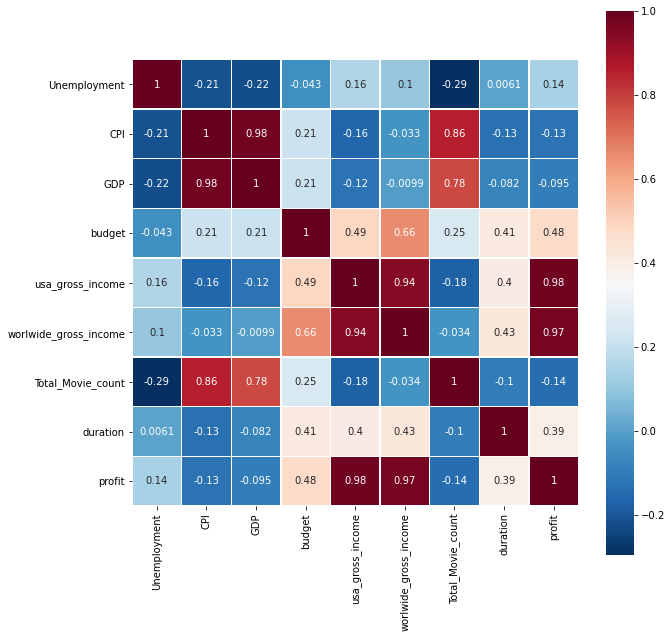

In [39]:
fig, ax = plt.subplots(figsize=(10,10)) 
feats = subsample[cont_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

In [40]:
# Categorical features - need to convert to numerical codes
cat_data = X.drop(labels=cont_vars,axis=1)
#cat_data = cat_data.astype('category')
#cat_data = cat_data.apply(lambda x: x.cat.codes,axis=0)

# Run mutual info test
mutual_info_test = SelectKBest(score_func=mutual_info_regression, k='all')
mutual_info_fit = mutual_info_test.fit(cat_data,y)

# Put scores and features names in a dataframe
mi_scores = pd.DataFrame(mutual_info_fit.scores_)
dfcolumns = pd.DataFrame(cat_data.columns)
mi_scores = pd.concat([dfcolumns,mi_scores],axis=1)
mi_scores.columns = ['Feature','Score']  

mi_scores

,Feature,Score
0,president,0.00
1,year,0.00
2,IMDB_Title,0.08
3,original_title,0.02
4,day_of_year,0.01
5,genre,0.04
6,director,0.09
7,writer,0.00
8,production_company,0.00
9,avg_vote,0.18


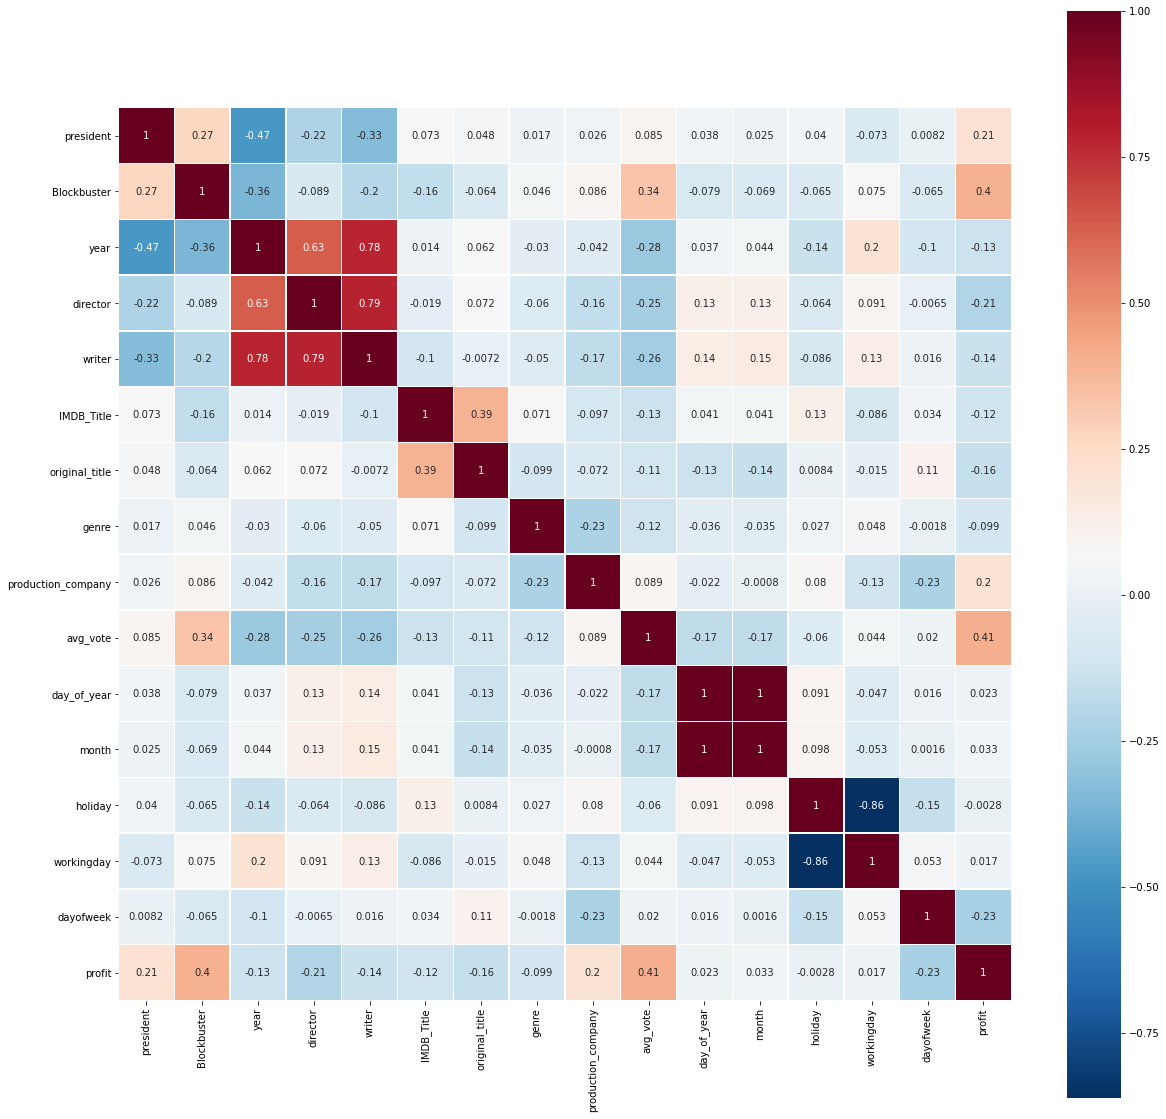

In [41]:
fig, ax = plt.subplots(figsize=(20,20)) 

feats = subsample[cat_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

# Alchohol

In [42]:
wine_data_US = wine_data.loc[wine_data['Code'] == 'USA'] # Looking at only US based movies
beer_data_US = beer_data.loc[wine_data['Code'] == 'USA']
spirits_data_US = spirits_data.loc[wine_data['Code'] == 'USA']
wine_data_US.head()

,Country,Code,Year,Wine
8505,United States,USA,1960,0.83
8506,United States,USA,1961,0.87
8507,United States,USA,1962,0.83
8508,United States,USA,1963,0.87
8509,United States,USA,1964,0.91


In [43]:
Alcohol_merge = pd.merge(wine_data_US,beer_data_US,how='left', left_on=['Year','Code','Country'], right_on=['Year','Code','Country'])

Alcohol_merge = pd.merge(spirits_data_US,Alcohol_merge,how='right', left_on=['Year','Code','Country'], right_on=['Year','Code','Country'])
#Alcohol_merge = Alcohol_merge.rename({'Beer Liters': 'Sprits','Beer Liters_x': 'Wines','Beer Liters_y':'Beer'}, axis='columns')
Alcohol_merge = Alcohol_merge.drop(columns=['Country','Code'])
Alcohol_merge.head()

,Year,Spirits,Wine,Beer
0,1960,3.26,0.83,nan
1,1961,3.26,0.87,3.67
2,1962,3.41,0.83,3.75
3,1963,3.44,0.87,3.82
4,1964,3.60,0.91,3.94


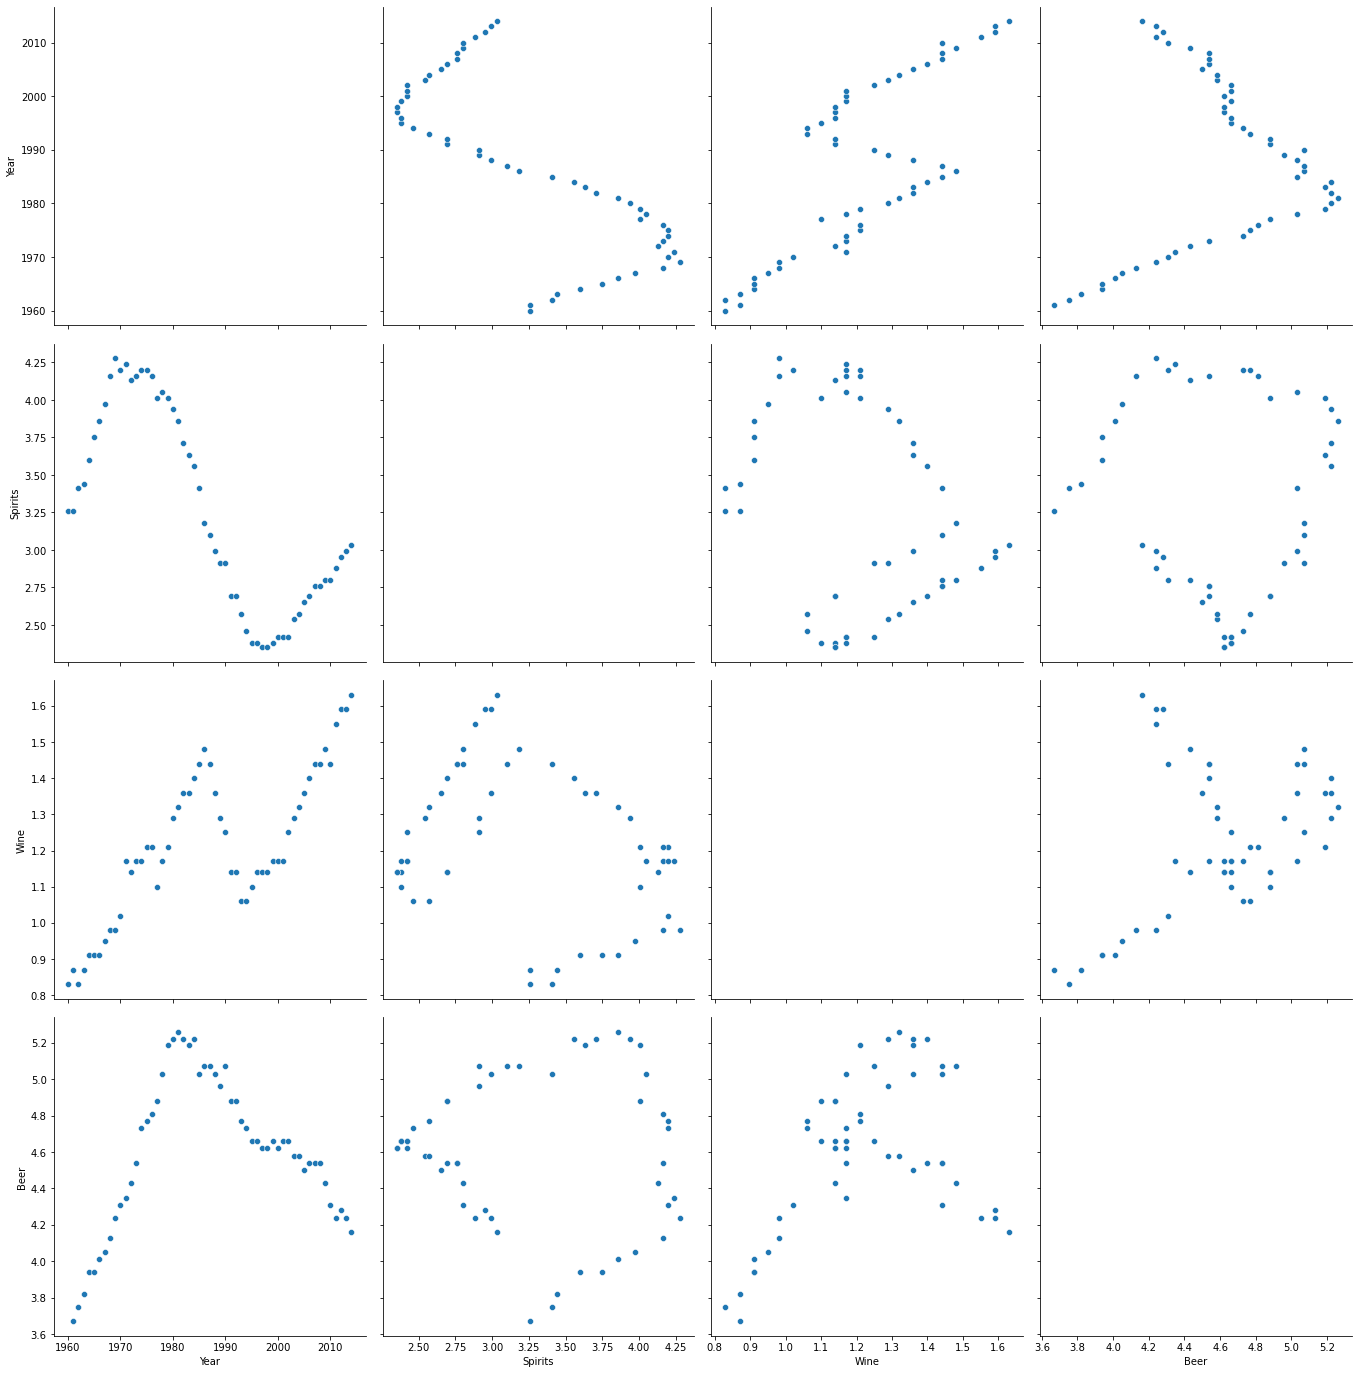

In [44]:
Alcohol_merge
g = sns.pairplot(data=Alcohol_merge,diag_kind='reg')
g.fig.set_size_inches(20,20)

In [46]:
IMDB_MERGE_All = pd.merge(IMDB_MERGE_PRESIDENT,Alcohol_merge,how='right', left_on=['year'], right_on=['Year'])
IMDB_MERGE_All = IMDB_MERGE_All.dropna() # Dropping any rows with null value
#print(IMDB_MERGE_All.isna().sum(),IMDB_MERGE_All.shape)
#IMDB_MERGE_All.loc[IMDB_MERGE_All.president.isna()]
#IMDB_MERGE_All.head().T

In [47]:
cont_vars = ['Spirits','Wine','Beer','Unemployment','CPI','GDP','budget','usa_gross_income','worlwide_gross_income','Total_Movie_count','duration'] # Continuous variables
cat_vars = ['president','Blockbuster','year','director','writer','IMDB_Title','original_title','genre',
            'production_company','avg_vote','day_of_year','month','holiday','workingday','dayofweek'] # Catogrorical Variables


subsample = IMDB_MERGE_All.sample(n=100)
X = subsample.drop(labels=['profit'],axis=1)
y = subsample['profit']

cont_data = X[cont_vars]

ftest = SelectKBest(score_func=f_regression, k='all')
fit_ftest = ftest.fit(cont_data,y)
f_scores = pd.DataFrame(fit_ftest.scores_)
dfcolumns = pd.DataFrame(cont_data.columns)
f_scores = pd.concat([dfcolumns,f_scores],axis=1)
f_scores.columns = ['Feature','F-Score']  
f_scores

#data_feat_sel.head()
#print(data)

,Feature,F-Score
0,Spirits,1.10
1,Wine,0.32
2,Beer,0.00
3,Unemployment,1.62
4,CPI,1.32
5,GDP,1.28
6,budget,62.68
7,usa_gross_income,"2,184.66"
8,worlwide_gross_income,"4,484.05"
9,Total_Movie_count,0.25


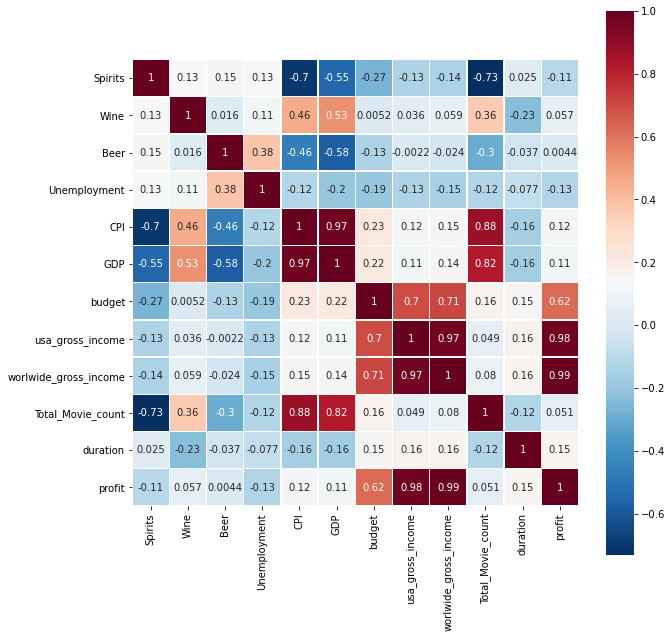

In [48]:
fig, ax = plt.subplots(figsize=(10,10)) 
feats = subsample[cont_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

In [49]:
# Categorical features - need to convert to numerical codes
cat_data = X.drop(labels=cont_vars,axis=1)
#cat_data = cat_data.astype('category')
#cat_data = cat_data.apply(lambda x: x.cat.codes,axis=0)

# Run mutual info test
mutual_info_test = SelectKBest(score_func=mutual_info_regression, k='all')
mutual_info_fit = mutual_info_test.fit(cat_data,y)

# Put scores and features names in a dataframe
mi_scores = pd.DataFrame(mutual_info_fit.scores_)
dfcolumns = pd.DataFrame(cat_data.columns)
mi_scores = pd.concat([dfcolumns,mi_scores],axis=1)
mi_scores.columns = ['Feature','Score']  

mi_scores

,Feature,Score
0,president,0.02
1,year,0.00
2,IMDB_Title,0.06
3,original_title,0.00
4,day_of_year,0.00
5,genre,0.00
6,director,0.00
7,writer,0.05
8,production_company,0.00
9,avg_vote,0.03


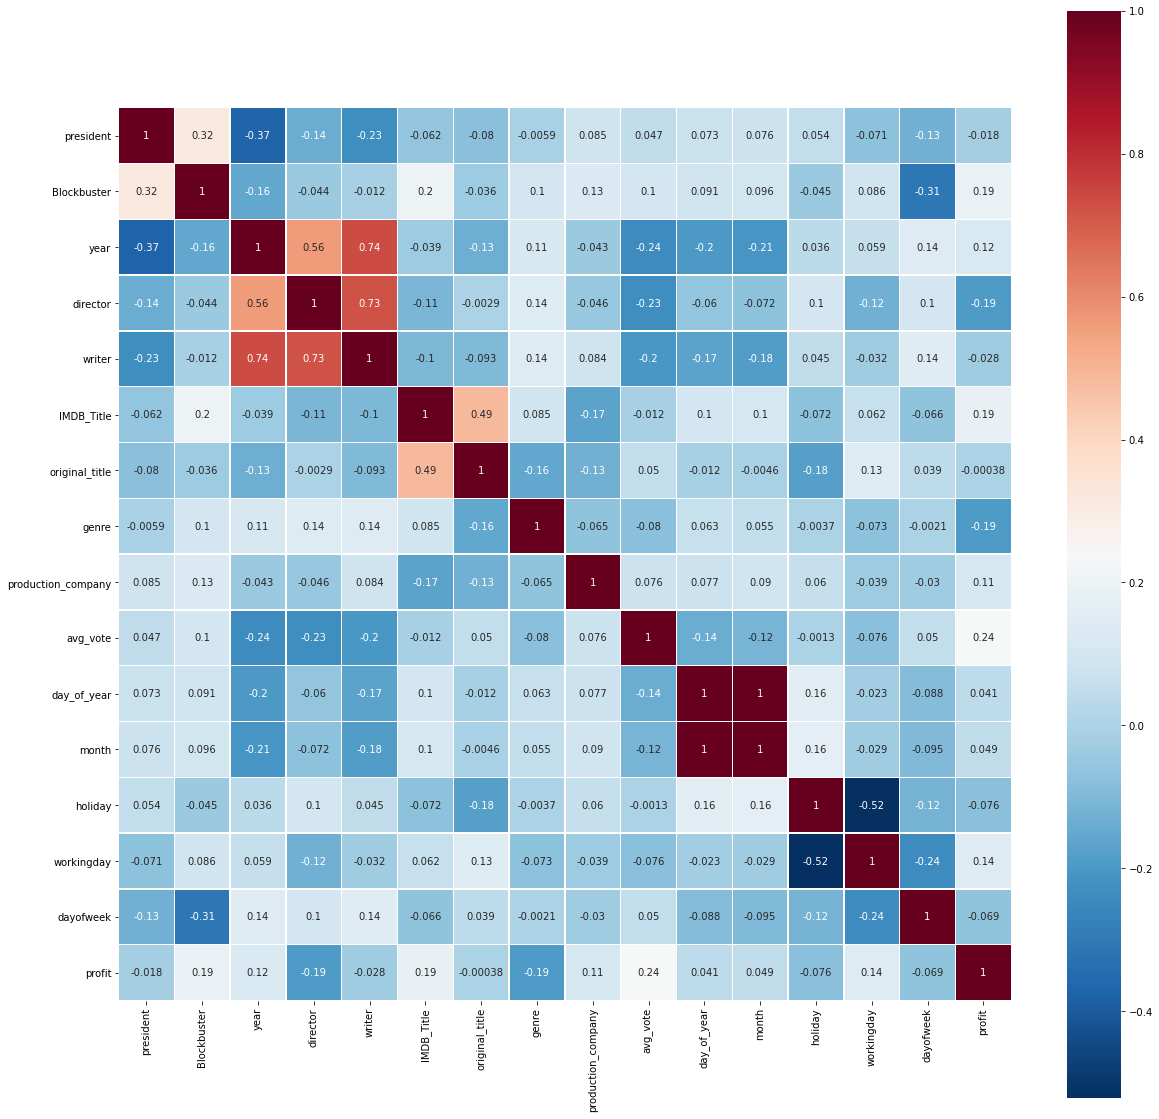

In [50]:
fig, ax = plt.subplots(figsize=(20,20)) 

feats = subsample[cat_vars+['profit']]
cm = feats.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True,ax=ax)
plt.show()

# Select features for model

In [51]:
IMDB_MERGE_All_selected = IMDB_MERGE_All.copy()
selected = ['profit','month','day_of_year','avg_vote','writer','Blockbuster','duration','budget','usa_gross_income','worlwide_gross_income','GDP']
IMDB_MERGE_All_selected = IMDB_MERGE_All[selected]
IMDB_MERGE_All_selected

,profit,month,day_of_year,avg_vote,writer,Blockbuster,duration,budget,usa_gross_income,worlwide_gross_income,GDP
3,"75,712,000.00",9.00,249.00,7.20,158.00,1.00,126.00,"5,000,000.00","40,356,000.00","40,356,000.00","563,300,000,000.00"
4,"75,712,000.00",9.00,249.00,7.20,158.00,1.00,126.00,"5,000,000.00","40,356,000.00","40,356,000.00","563,300,000,000.00"
5,"75,712,000.00",9.00,249.00,7.20,158.00,1.00,126.00,"5,000,000.00","40,356,000.00","40,356,000.00","563,300,000,000.00"
6,"356,906,196.00",11.00,334.00,7.20,159.00,1.00,79.00,"4,000,000.00","144,880,014.00","216,026,182.00","563,300,000,000.00"
7,"356,906,196.00",11.00,334.00,7.20,159.00,1.00,79.00,"4,000,000.00","144,880,014.00","216,026,182.00","563,300,000,000.00"
...,...,...,...,...,...,...,...,...,...,...,...
4050,"57,814,440.00",10.00,289.00,4.90,"2,380.00",0.00,105.00,"15,000,000.00","33,392,973.00","39,421,467.00","14,448,900,000,000.00"
4051,"-119,760.00",4.00,108.00,1.70,"2,701.00",0.00,89.00,"150,000.00","15,120.00","15,120.00","14,448,900,000,000.00"
4052,"-119,760.00",4.00,108.00,1.70,"2,701.00",0.00,89.00,"150,000.00","15,120.00","15,120.00","14,448,900,000,000.00"
4053,"90,467,842.00",9.00,254.00,4.50,"2,113.00",0.00,113.00,"13,000,000.00","51,733,921.00","51,733,921.00","14,448,900,000,000.00"


In [57]:
IMDB_MERGE_All_standardized = IMDB_MERGE_All_selected#['year','budget','usa_gross_income','worlwide_gross_income','profit']]
# Calculate mean and stdev
u = IMDB_MERGE_All_standardized.mean(axis=0)
stdev = IMDB_MERGE_All_standardized.std(axis=0)

# Calculate the standardized data
IMDB_MERGE_All_standardized = (IMDB_MERGE_All_standardized-u) / stdev


In [58]:
pca = PCA(2).fit(IMDB_MERGE_All_standardized)

# Project the data onto the new principal components axes
projected = pca.transform(IMDB_MERGE_All_standardized)

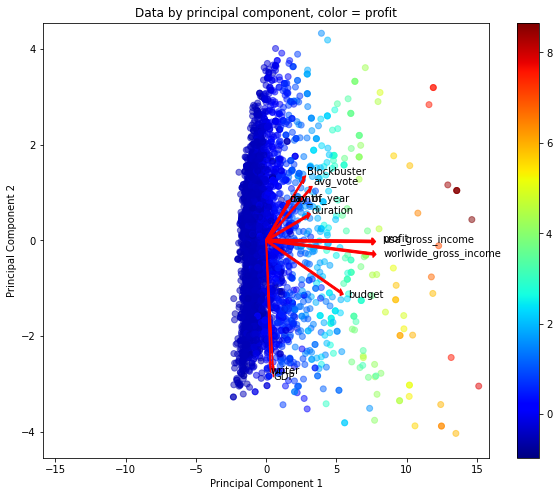

In [61]:
components = np.transpose(pca.components_[0:2, :])
fig,ax = plt.subplots(figsize=(10,8))
plt.scatter(x=projected[:,0],y=projected[:,1],alpha=0.5,c=IMDB_MERGE_All_standardized['profit'],cmap=plt.cm.get_cmap('jet',10000))
for i in range(components.shape[0]):
    ax.arrow(0,0,components[i,0]*np.max(projected[:,0]),components[i,1]*np.max(projected[:,1]),color='r',width=0.05)
    plt.annotate(IMDB_MERGE_All_standardized.columns[i],xy=(components[i,0]*np.max(projected[:,0])*1.1,components[i,1]*np.max(projected[:,1])*1.1))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-1.05*np.max(projected[:,0]),1.05*np.max(projected[:,0]))
plt.ylim(-1.05*np.max(projected[:,1]),1.05*np.max(projected[:,1]))
plt.title('Data by principal component, color = profit')
plt.colorbar()

plt.show()

In [60]:
IMDB_MERGE_All_standardized

,profit,month,day_of_year,avg_vote,writer,Blockbuster,duration,budget,usa_gross_income,worlwide_gross_income,GDP
3,0.01,0.73,0.63,0.94,-1.42,2.70,1.17,-0.64,0.08,-0.18,-2.09
4,0.01,0.73,0.63,0.94,-1.42,2.70,1.17,-0.64,0.08,-0.18,-2.09
5,0.01,0.73,0.63,0.94,-1.42,2.70,1.17,-0.64,0.08,-0.18,-2.09
6,1.87,1.31,1.45,0.94,-1.42,2.70,-1.46,-0.67,2.03,1.33,-2.09
7,1.87,1.31,1.45,0.94,-1.42,2.70,-1.46,-0.67,2.03,1.33,-2.09
...,...,...,...,...,...,...,...,...,...,...,...
4050,-0.11,1.02,1.02,-1.33,1.35,-0.37,-0.00,-0.29,-0.05,-0.19,1.53
4051,-0.49,-0.74,-0.72,-4.49,1.75,-0.37,-0.90,-0.81,-0.67,-0.53,1.53
4052,-0.49,-0.74,-0.72,-4.49,1.75,-0.37,-0.90,-0.81,-0.67,-0.53,1.53
4053,0.11,0.73,0.68,-1.73,1.02,-0.37,0.44,-0.36,0.29,-0.08,1.53


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

X = IMDB_MERGE_All_standardized['Blockbuster']
X=X.values.reshape(-1,1)
Y = IMDB_MERGE_All_standardized[IMDB_MERGE_All_standardized.drop(columns = ['Blockbuster']).columns]

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2) # giving a 80 - 20 test, train split 
model = LinearRegression().fit(x_train, y_train)
predictions = model.predict(x_test)
R_squared = r2_score(y_test, predictions)
MSE = metrics.mean_absolute_error(y_test, predictions)
RMSE = np.sqrt(MSE)
print(R_squared)
print(MSE)
print(RMSE)
print(model.score(x_train, y_train))

0.04419087921170463
0.7353694377469239
0.8575368433757956
0.048498981764355076
